# Generate Crops

## Generate Crops with Mask2Former

In [1]:
#! pip install -U transformers huggingface-hub

In [2]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import transformers
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from matplotlib import pyplot as plt

2023-03-02 11:44:35.166297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
processor_segm = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
model_segm = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
to_tensor = transforms.ToTensor()
to_image = transforms.ToPILImage()

In [4]:
def local_crops_2(image):
  # tensorize the image

    img_tensor = to_tensor(image)

  # preprocess the image for the model
    inputs = processor_segm(image, return_tensors="pt")

  # Apply the model and get the masks prediction
    with torch.no_grad():
        outputs = model_segm(**inputs)
    prediction = processor_segm.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    output_tensor = prediction['segmentation'] 

    crops = []
    bboxs = []
    crops_unmasked = []
    count_box_tensor = torch.zeros(output_tensor.shape)
    for i in range(int(torch.max(output_tensor) + 1)):
    # find the mask in the output_tensor
        if not (output_tensor == i).any().item():
            continue
        mask = torch.zeros(output_tensor.shape)
        mask[output_tensor == i] = 1
    # Apply the mask to the image
        masked_img_tensor = img_tensor*mask.expand(3, -1, -1)

    # Compute the bounding box of the non-zero pixels in the masked image
        nonzero_indices = torch.nonzero(masked_img_tensor.sum(dim=0))
        x_min, y_min = nonzero_indices.min(dim=0)[0]
        x_max, y_max = nonzero_indices.max(dim=0)[0]
        bbox = (int(y_min), int(x_min), int(y_max), int(x_max))
    
    # Crop the unmasked part of the image and 
        masked_img = to_image(masked_img_tensor)
        crops+= [masked_img.crop(bbox)]
        crops_unmasked += [image.crop(bbox)]
        bboxs +=[bbox]
        
        count_box_tensor[bbox[1]:bbox[3], bbox[0]:bbox[2]] +=1.

    return crops,crops_unmasked, bboxs, count_box_tensor

## Display & test

In [5]:
def display_img_list(crops):
  # Compute the dimensions of the new image to display the images in
    total_width = max(img.width for img in crops)
    max_height = sum(img.height for img in crops)
    display_img = Image.new("RGB", (total_width, max_height))

  # Paste each image onto the new image
    y_offset = 0
    for img in crops:
        display_img.paste(img, (0, y_offset))
        y_offset += img.height
    return display_img
def display_tensor_list(crops):
  # Compute the dimensions of the new image to display the images in
    total_width = max(to_image(img).width for img in crops)
    max_height = sum(to_image(img).height for img in crops)
    display_img = Image.new("RGB", (total_width, max_height))

  # Paste each image onto the new image
    y_offset = 0
    for img in crops:
        display_img.paste(to_image(img), (0, y_offset))
        y_offset += to_image(img).height
    return display_img

In [6]:
#!ln -s /System/Applications/Preview.app /Applications/Preview.app
image = Image.open("4.jpg")
crops,crops_unmasked, bboxs,count_box_tensor = local_crops_2(image)

tensor(8.)


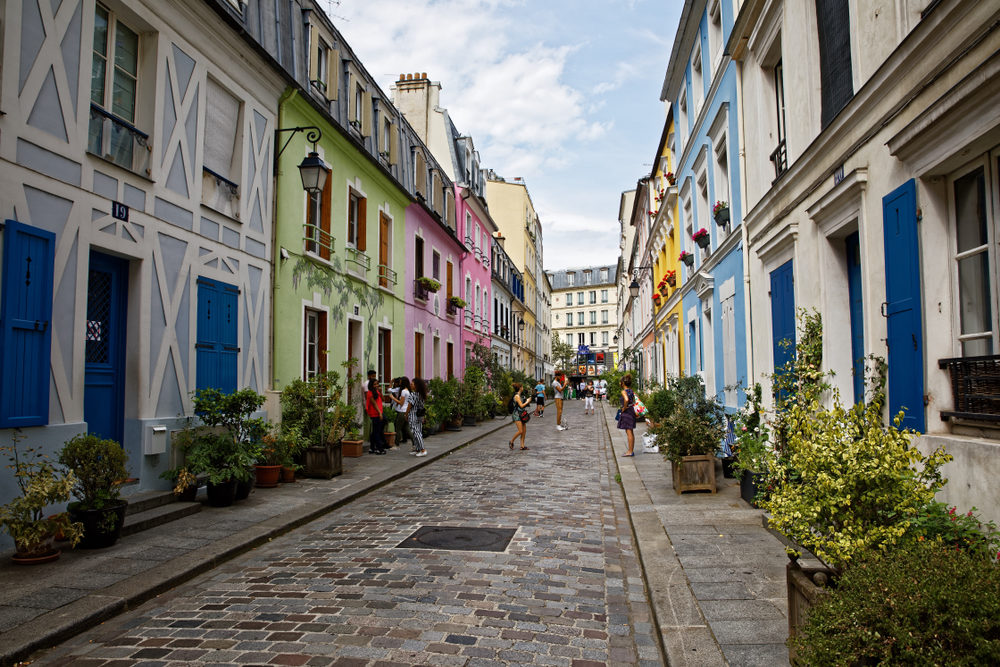

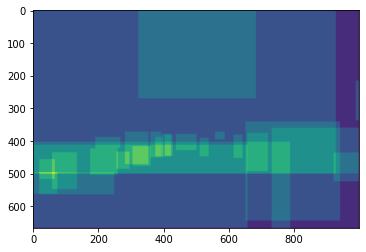

In [7]:
print(count_box_tensor.max())
plt.imshow(count_box_tensor)
image

27


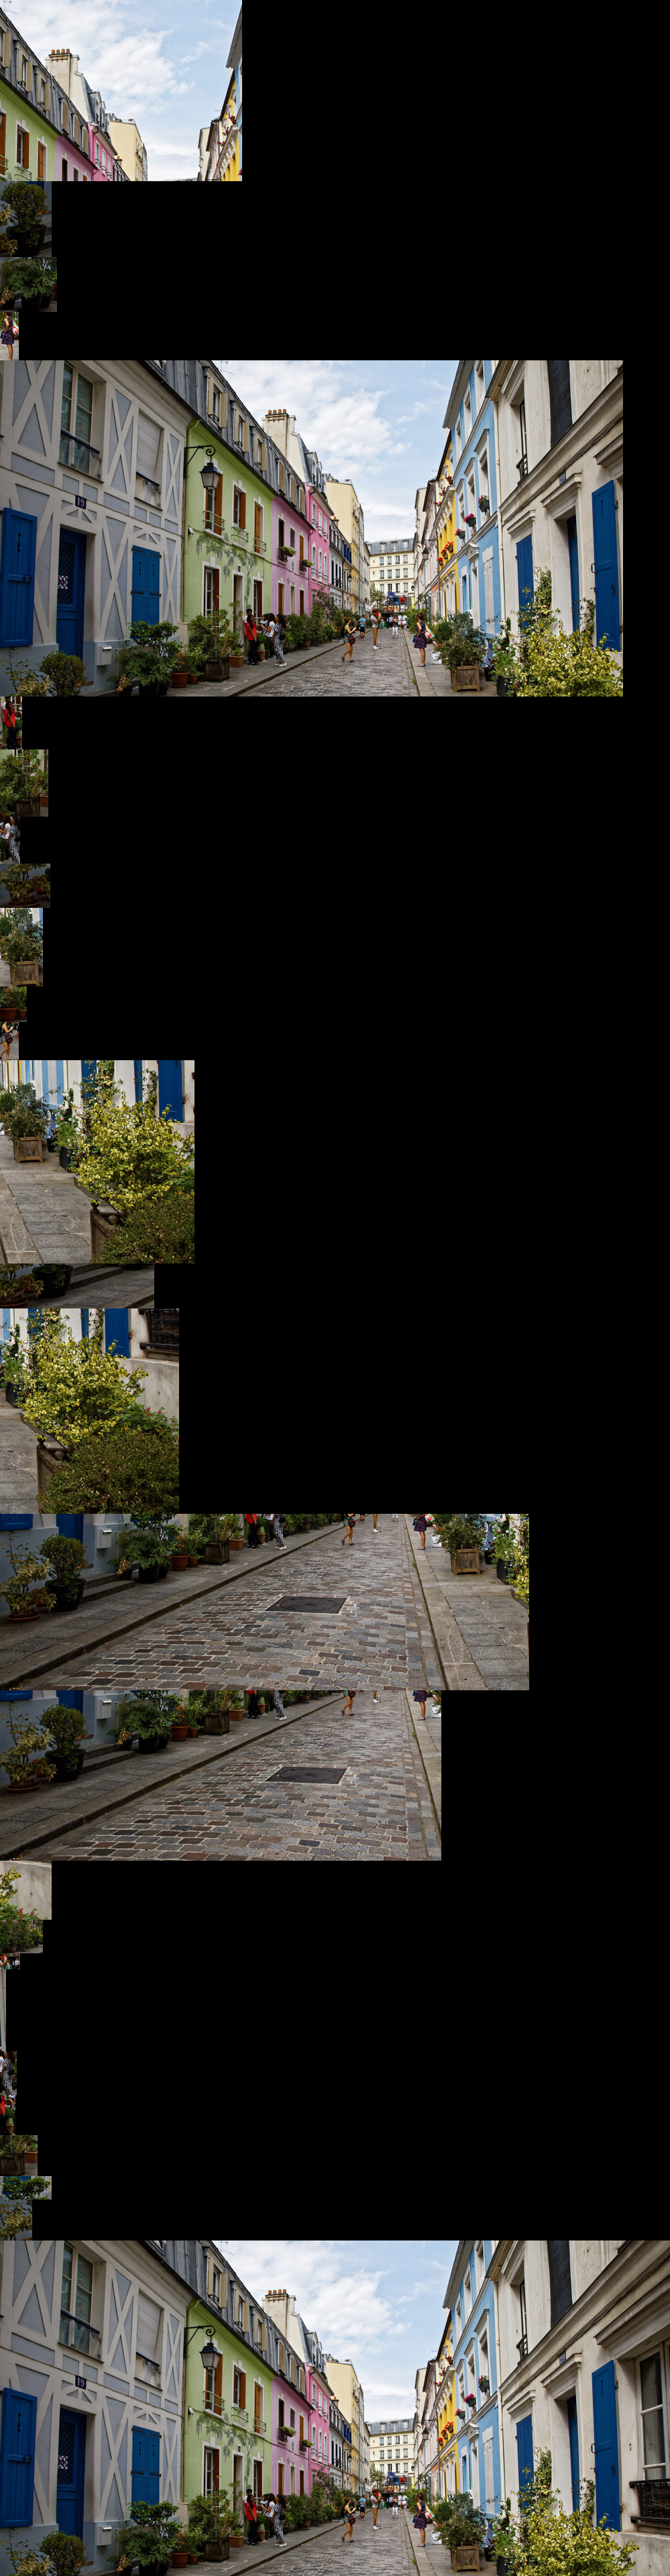

In [8]:
print(len(crops))
display_img_list(crops_unmasked)

## CamVid

In [69]:
import os
import torch
import torch.utils.data as data
import numpy as np
from PIL import Image
from torchvision.datasets.folder import default_loader
from inferno.utils.exceptions import assert_
from inferno.io.transform.base import Compose
from inferno.io.transform.generic import Normalize, NormalizeRange, Cast, AsTorchBatch, Label2OneHot
from inferno.io.transform.image import \
    RandomSizedCrop, RandomGammaCorrection, RandomFlip, Scale, PILImage2NumPyArray
from matplotlib import pyplot as plt
try:
    from torchvision.datasets.folder import is_image_file
except ImportError:
    from torchvision.datasets.folder import IMG_EXTENSIONS, has_file_allowed_extension


    def is_image_file(filename):
        return has_file_allowed_extension(filename, IMG_EXTENSIONS)

    




CAMVID_CLASSES = ['Sky',
                  'Building',
                  'Column-Pole',
                  'Road',
                  'Sidewalk',
                  'Tree',
                  'Sign-Symbol',
                  'Fence',
                  'Car',
                  'Pedestrain',
                  'Bicyclist',
                  'Void']

# weights when using median frequency balancing used in SegNet paper
# https://arxiv.org/pdf/1511.00561.pdf
# The numbers were generated by:
# https://github.com/yandex/segnet-torch/blob/master/datasets/camvid-gen.lua
CAMVID_CLASS_WEIGHTS = [0.58872014284134,
                        0.51052379608154,
                        2.6966278553009,
                        0.45021694898605,
                        1.1785038709641,
                        0.77028578519821,
                        2.4782588481903,
                        2.5273461341858,
                        1.0122526884079,
                        3.2375309467316,
                        4.1312313079834,
                        0]
# mean and std
CAMVID_MEAN = [0.41189489566336, 0.4251328133025, 0.4326707089857]
CAMVID_STD = [0.27413549931506, 0.28506257482912, 0.28284674400252]

CAMVID_CLASS_COLORS = [
    (128, 128, 128),
    (128, 0, 0),
    (192, 192, 128),
    (128, 64, 128),
    (0, 0, 192),
    (128, 128, 0),
    (192, 128, 128),
    (64, 64, 128),
    (64, 0, 128),
    (64, 64, 0),
    (0, 128, 192),
    (0, 0, 0),
]

def make_dataset(dir):
    images = []
    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                item = path
                images.append(item)
    return images



def label_to_long_tensor(pic):
    label = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
    label = label.view(pic.size[1], pic.size[0], 1)
    label = label.transpose(0, 1).transpose(0, 2).squeeze().contiguous().long()
    return label



def label_to_pil_image(label):
    label = label.unsqueeze(0)
    colored_label = torch.zeros(3, label.size(1), label.size(2)).byte()
    for i, color in enumerate(CAMVID_CLASS_COLORS):
        mask = label.eq(i)
        for j in range(3):
            colored_label[j].masked_fill_(mask, color[j])
    npimg = colored_label.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    mode = None
    if npimg.shape[2] == 1:
        npimg = npimg[:, :, 0]
        mode = "L"

    return Image.fromarray(npimg, mode=mode)



class CamVid(data.Dataset):
    SPLIT_NAME_MAPPING = {'train': 'train',
                          'training': 'train',
                          'validate': 'val',
                          'val': 'val',
                          'validation': 'val',
                          'test': 'test',
                          'testing': 'test'}
    # Dataset statistics
    CLASS_WEIGHTS = CAMVID_CLASS_WEIGHTS
    CLASSES = CAMVID_CLASSES
    MEAN = CAMVID_MEAN
    STD = CAMVID_STD

    def __init__(self, root, split='train',
                 image_transform=None, label_transform=None, joint_transform=None,
                 download=False, loader=default_loader, raw_image_transform = None):
        # Validate
        assert_(split in self.SPLIT_NAME_MAPPING.keys(),
                "`split` must be one of {}".format(set(self.SPLIT_NAME_MAPPING.keys())),
                KeyError)
        # Root directory and split
        self.root_directory = root
        self.split = self.SPLIT_NAME_MAPPING.get(split)
        # Utils
        self.image_loader = loader
        # Transforms
        self.image_transform = image_transform
        self.raw_image_transform = raw_image_transform
        self.label_transform = label_transform
        self.joint_transform = joint_transform
        # For when we implement download:
        if download:
            self.download()
        # Make dataset with paths to the image
        self.image_paths = make_dataset(os.path.join(self.root_directory, self.split))
        #print(self.image_paths)
    def __getitem__(self, index):
        path = self.image_paths[index]
        image = self.image_loader(path)
        #plt.plot(image)
        #print(type(image))
        #plt.imshow(image)
        label = Image.open(path.replace(self.split, self.split + 'annot'))
        # Apply transforms
        if self.raw_image_transform is not None:
            raw_image = self.raw_image_transform(image)
        if self.image_transform is not None:
            image = self.image_transform(image)
        
        if self.label_transform is not None:
            label = self.label_transform(label)
        if self.joint_transform is not None:
            image, label = self.joint_transform(image, label)
        
        #get boxes
        crops,crops_unmasked, bboxs, count_box_tensor = local_crops_2(raw_image)
        crops_preprocessed = []
        for crop_unmasked in crops_unmasked:
            crops_preprocessed+= [self.image_transform(crop_unmasked)]
        return image, crops_preprocessed, label, bboxs, count_box_tensor, raw_image

    def __len__(self):
        return len(self.image_paths)

    def download(self):
        # TODO: please download the dataset from
        # https://github.com/alexgkendall/SegNet-Tutorial/tree/master/CamVid
        raise NotImplementedError
     
    
    

def denormalize_image(image: torch.Tensor) -> torch.Tensor:
    image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to('cpu')
    image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to('cpu')
    image *= image_std[:, None, None]    
    image += image_mean[:, None, None]
    return image

def show_crop_preprocessed(dataset, _id = 0, number_of_crops = 16):
    plt.figure(figsize=(10, 10))
    d_sub = torch.utils.data.Subset(dataset[_id][1], np.random.choice(len(dataset[_id][1]), number_of_crops, replace=False))
    # Show all images from the dataset since our dataset is small
    for idx, crop in enumerate(d_sub):

        plt.subplot(4, 4, idx+1)
        plt.imshow(denormalize_image(crop).permute(1, 2, 0))
        plt.title(f"{idx}")
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()
    
    
def list_to_tensor(l):
    size = (len(l),)+tuple(list(l[0].size()))
    b = torch.Tensor(*size)
    b = torch.stack(l)
    return b

def get_features_for_one_image_and_its_clips(dataset, _id, model):
    inputs = dataset[_id]
    image, crops_preprocessed, label, bboxs, count_box_tensor, raw_image = inputs
    crops_inputs = list_to_tensor(crops_preprocessed)
    
    #for crops
    with torch.no_grad():
        crops_features = model.encode_image(crops_inputs)
        image = image.unsqueeze(0).to(device)
        image_features = model.encode_image(image)
    
    
    return image_features, crops_features, bboxs, count_box_tensor


def pixelwise_embedding(comined_features, bboxs, count_box_tensor):
    size = tuple(count_box_tensor.size())+ (comined_features[0].size()[0],)
    count_box_tensors = count_box_tensor.unsqueeze(2).repeat(1,1, comined_features[0].size()[0])
    pixelwise_embedding = torch.zeros(size)
    for idx, bbox in enumerate(bboxs):
        pixelwise_embedding[bbox[1]:bbox[3], bbox[0]:bbox[2], :] += comined_features[idx]
        
    return pixelwise_embedding/count_box_tensors



from sklearn.metrics import accuracy_score

def get_segmentation_mask(image_features, model, class_names):
    """
    image_features: torch.Tensor of size (n_samples, H, W, emb_dim)
    """
    # getting text tokens
    class_captions = [f"An image depicting a {x}" for x in class_names]
    text_input = clip.tokenize(class_captions).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    text_probs = (image_features @ text_features.T).softmax(dim=-1)
    masks = torch.argmax(text_probs, dim=-1)
    return masks

def validate(gt, pred):
    return {
        'Accuracy': accuracy_score(gt.flatten(), pred.flatten())
    }    


def feature_fusion(f_local, f_global, tau=1, epsilon=1e-6):
    """
    Performs feature Fusion described in https://concept-fusion.github.io/assets/pdf/2023-ConceptFusion.pdf
    
    local_features: Torch.Tensor of size (R, emb_dim)
    global_feature: Torch.Tensor of size (1, emb_dim)
    
    """
    f_global = f_global.view(-1)
    def cosine_similarity(f1, f2, epsilon=epsilon):
        f1 = f1.to(torch.float32)
        f2 = f2.to(torch.float32)
        return torch.dot(f1, f2)/(torch.linalg.norm(f1)*torch.linalg.norm(f2) + epsilon)
    
    R = f_local.size()[0]
    
    psi = torch.tensor([cosine_similarity(f, f_global) for f in f_local])
    phi_matrix = [[cosine_similarity(f1, f2) for f2 in f_local] for f1 in f_local]
    phi = torch.tensor([(np.sum(phi_row) - phi_matrix[i][i])/R for i, phi_row in enumerate(phi_matrix)])
    
    _exp = torch.exp((psi+phi)/tau)
    w = _exp/torch.sum(_exp)
    
    return ((1-w)*f_local.T).T + w[..., None]*f_global

classes = list({0: 'Animal',
 1: 'Archway',
 2: 'Bicyclist',
 3: 'Bridge',
 4: 'Building',
 5: 'Car',
 6: 'CartLuggagePram',#
 7: 'Child',
 8: 'Column pole',
 9: 'Fence',
 10: 'Lane markings drivable',
 11: 'Lane markings non drivable',
 12: 'Misc text',
 13: 'Motorcycle scooter',
 14: 'Other moving',
 15: 'Parking block',
 16: 'Pedestrian',
 17: 'Road',
 18: 'Road shoulder',
 19: 'Sidewalk',
 20: 'Sign symbol',
 21: 'Sky',
 22: 'Pickup truck',
 23: 'Traffic cone',
 24: 'Traffic light',
 25: 'Train',
 26: 'Tree',
 27: 'Truck bus',
 28: 'Tunnel',
 29: 'Vegetation misc',
 30: 'Void',
 31: 'Wall'}.values())

color_map = {0: [64, 128, 64],
 1: [192, 0, 128],
 2: [0, 128, 192],
 3: [0, 128, 64],
 4: [128, 0, 0],
 5: [64, 0, 128],
 6: [64, 0, 192],
 7: [192, 128, 64],
 8: [192, 192, 128],
 9: [64, 64, 128],
 10: [128, 0, 192],
 11: [192, 0, 64],
 12: [128, 128, 64],
 13: [192, 0, 192],
 14: [128, 64, 64],
 15: [64, 192, 128],
 16: [64, 64, 0],
 17: [128, 64, 128],
 18: [128, 128, 192],
 19: [0, 0, 192],
 20: [192, 128, 128],
 21: [128, 128, 128],
 22: [64, 128, 192],
 23: [0, 0, 64],
 24: [0, 64, 64],
 25: [192, 64, 128],
 26: [128, 128, 0],
 27: [192, 128, 192],
 28: [64, 0, 64],
 29: [192, 192, 0],
 30: [0, 0, 0],
 31: [64, 192, 0]}
def seg_mask2tesor_image(segm_mask):
    segm_mask[0].size()
    size = (3,)+tuple(segm_mask[0].size())
    tensor_image = torch.zeros(size)
    for i in range(size[1]):
        for j in range(size[2]):
            #print(segm_mask[0][i][j].item())
            tensor_image[:,i,j] = torch.Tensor(color_map[segm_mask[0][i][j].item()])
    plt.imshow(tensor_image.int().permute(1, 2, 0))

In [70]:
import clip
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)
raw_image_transform = Compose()
d = CamVid("/Users/yaroslavtominin/Desktop/L'École Polytechnique 3/MAP/CamVid", image_transform=preprocess, raw_image_transform = raw_image_transform)
def predict_segmentation_mask(d, model, _id):
    
    show_crop_preprocessed(d, _id = _id)
    image_features, crops_features, bboxs, count_box_tensor = get_features_for_one_image_and_its_clips(d, _id, model)

    feature_fusions = feature_fusion(crops_features, image_features)
    
    pixelwise_embeddings = pixelwise_embedding(feature_fusions, bboxs, count_box_tensor)

    segm_mask = get_segmentation_mask(pixelwise_embeddings[None, ...], model, classes)
    #show raw image
    plt.imshow(d[_id][-1])
    plt.show()
    seg_mask2tesor_image(segm_mask)
    #classes

30
Problem with id = 30
199


<Figure size 720x720 with 0 Axes>

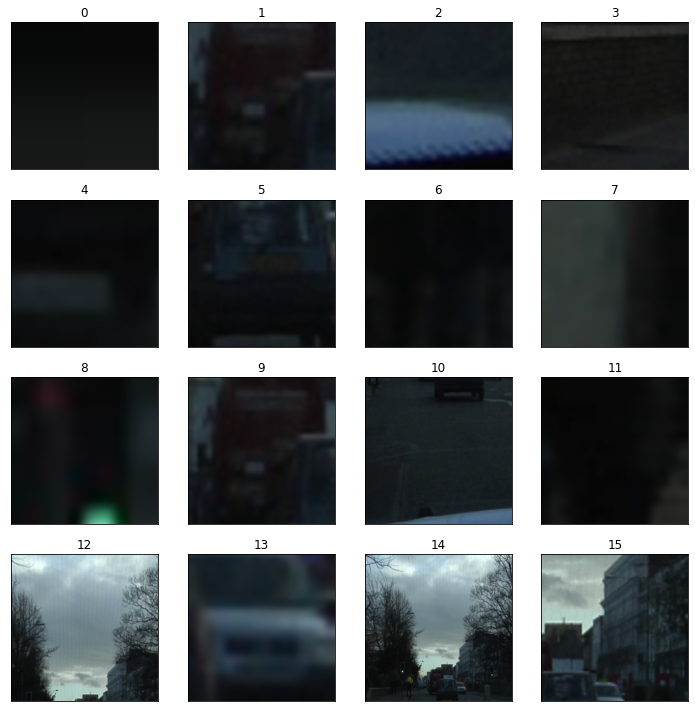

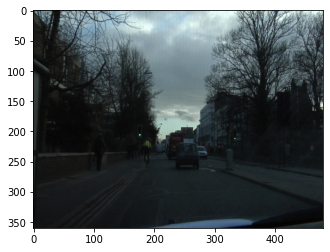

150


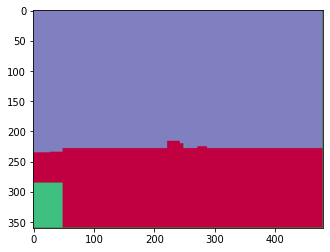

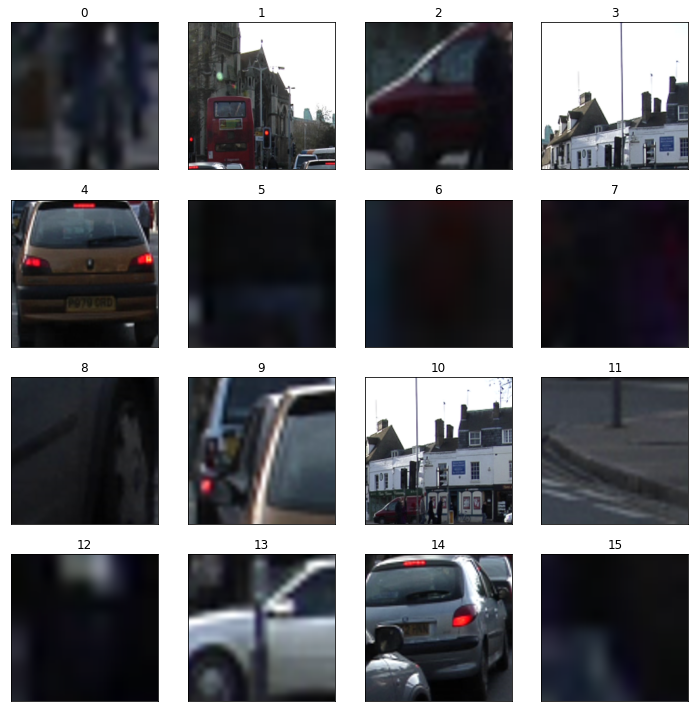

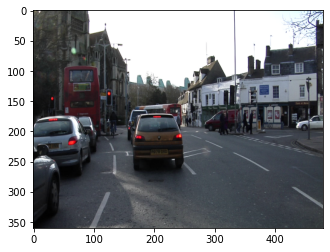

109


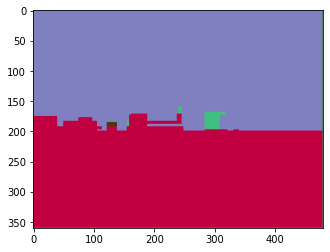

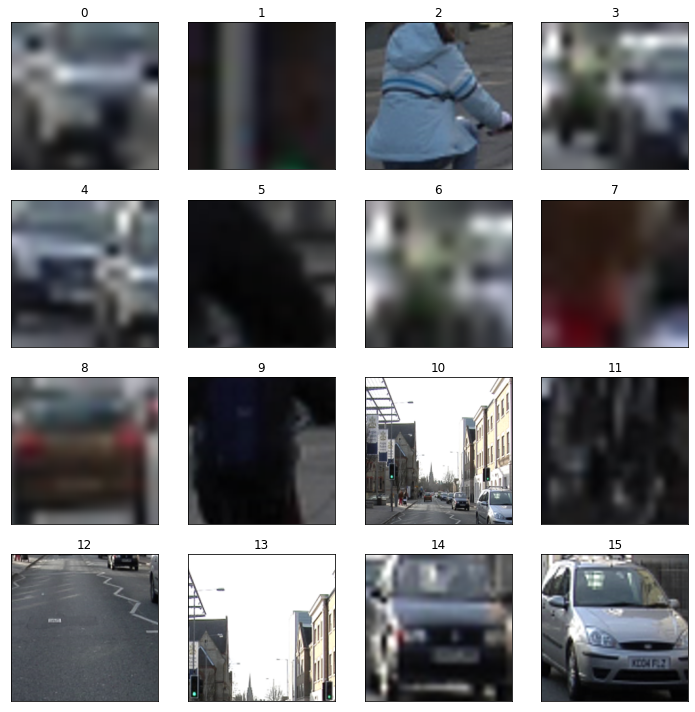

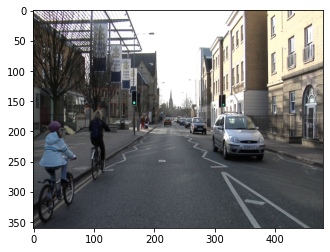

353


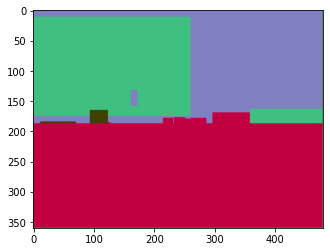

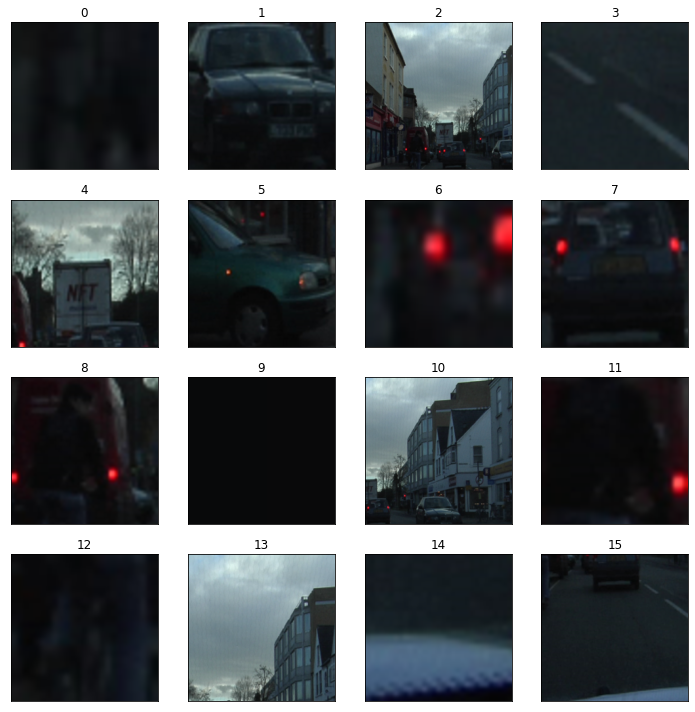

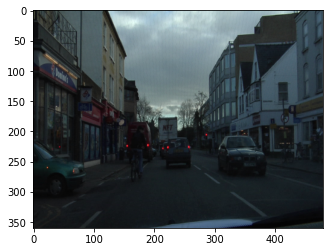

165


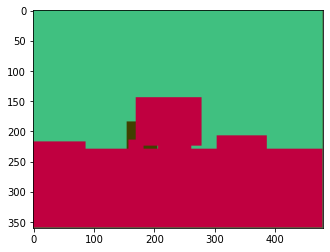

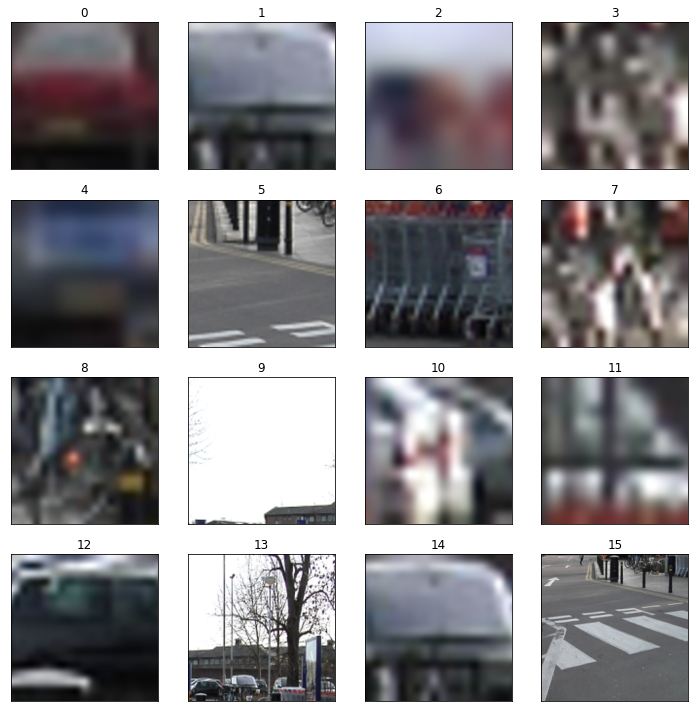

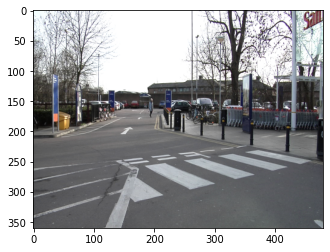

163
Problem with id = 163
329
Problem with id = 329
344


In [ ]:
import random
n = len(d)
#Generate 5 random numbers between 10 and 30
randomlist = random.sample(range(0, n), 10)
for _id in randomlist:
    print(_id)
    try:
        predict_segmentation_mask(d, model, _id)
    except:
        print(f"Problem with id = {_id}")